In [40]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering  # Hierarchical
from sklearn.cluster import KMeans  # Centroid-based
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture  # Model-based
from sklearn.cluster import HDBSCAN  # Density-based
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn')
sns.set_palette("husl")

In [11]:
end_date = datetime.now()
start_date = end_date - timedelta(days=2000)
n_regimes = 4
data = None
features = None
scaled_features = None
regime_results = {}


In [12]:
# Download data


nasdaq = yf.download('^IXIC', start=start_date)
vxn = yf.download('^VXN', start=start_date)

df = pd.DataFrame()
df['close'] = nasdaq['Close']
df['returns'] = nasdaq['Close'].pct_change()
df['volume'] = nasdaq['Volume']
df['vxn'] = vxn['Close']

# Calculate features that capture different market characteristics
# Trend features
df['sma_ratio'] = ta.trend.sma_indicator(df['close'], window=20) / ta.trend.sma_indicator(df['close'], window=50)

# Momentum
df['rsi'] = ta.momentum.rsi(df['close'])
df['macd'] = ta.trend.macd_diff(df['close'])

# Volatility
df['realized_vol'] = df['returns'].rolling(20).std() * np.sqrt(252)
df['vix_ratio'] = df['vxn'] / df['vxn'].rolling(20).mean()

# Volume
df['volume_ratio'] = df['volume'] / df['volume'].rolling(20).mean()

data = df.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [63]:
#Prepare features for regime detection
features = pd.DataFrame()

# Market state features
#features['trend'] = data['sma_ratio']
#features['momentum'] = data['rsi']
features['volatility'] = data['realized_vol']
#features['sentiment'] = data['vix_ratio']
#features['volume_activity'] = data['volume_ratio']

# Add lagged features for temporal context
for col in features.columns:
    features[f'{col}_lag1'] = features[col].shift(1)
    features[f'{col}_lag5'] = features[col].shift(5)

features = features.dropna()

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

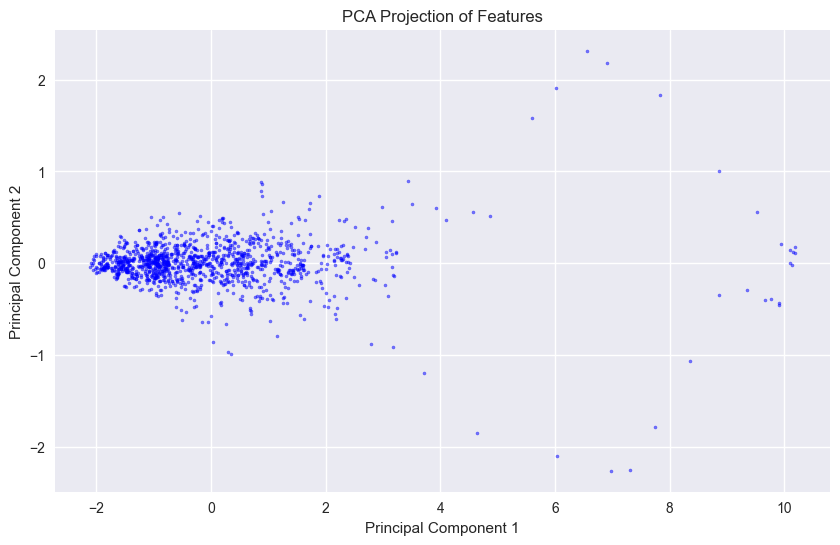

In [64]:
# PCA for Linear Dimensionality Reduction
pca = PCA(n_components=2)  # Reduce to 2D for visualization
pca_features = pca.fit_transform(scaled_features)

# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], alpha=0.5, s=5, c='blue')
plt.title('PCA Projection of Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

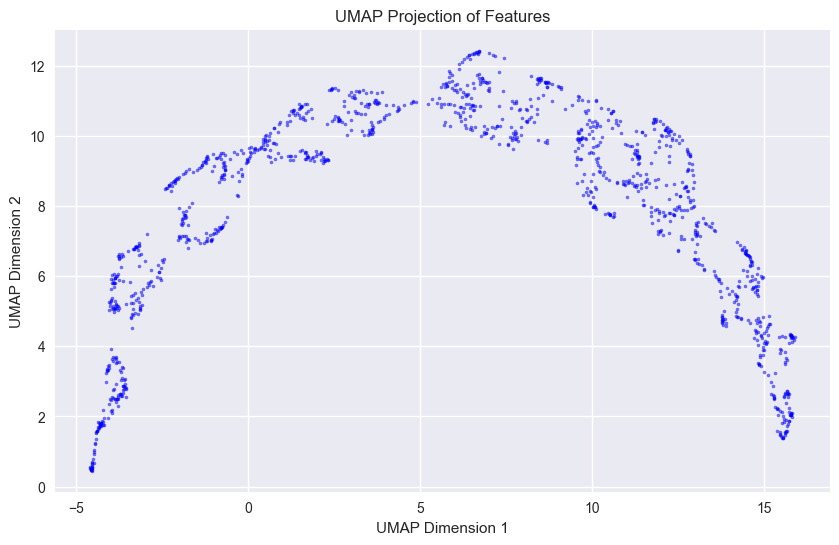

In [72]:
# UMAP for Non-linear Dimensionality Reduction
umap_reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
umap_features = umap_reducer.fit_transform(scaled_features)

# Plot UMAP results
plt.figure(figsize=(10, 6))
plt.scatter(umap_features[:, 0], umap_features[:, 1], alpha=0.5, s=5, c='blue')
plt.title('UMAP Projection of Features')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()

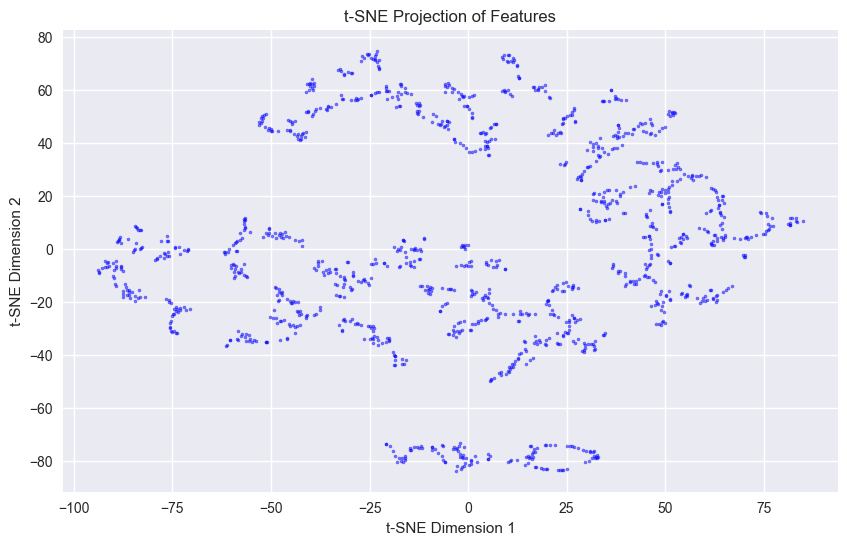

In [86]:
# t-SNE for Non-linear Dimensionality Reduction
tsne = TSNE(n_components=2, perplexity=10, learning_rate=1000, random_state=42, n_iter=1000)
tsne_features = tsne.fit_transform(scaled_features)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], alpha=0.5, s=5, c='blue')
plt.title('t-SNE Projection of Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

In [87]:
"""
Apply Hierarchical Clustering (Average Linkage)

Market Regime Justification:
- Captures nested structure of market regimes
- No assumptions about regime shape
- Can identify regimes at different scales
"""

hierarchical = AgglomerativeClustering(
    n_clusters=n_regimes,
    linkage='average'
)

regimes = hierarchical.fit_predict(scaled_features)

regime_results['hierarchical'] = {
            'regimes': regimes,
            'model': hierarchical,
            'davies_bouldin': davies_bouldin_score(scaled_features, regimes),
            'silhouette': silhouette_score(scaled_features, regimes)
}


In [88]:
"""
Apply K-means Clustering

Market Regime Justification:
- Markets tend to gravitate around equilibrium states
- Clear separation between different market conditions
- Simple interpretation of regime centers
"""

kmeans = KMeans(
    n_clusters=n_regimes,
    random_state=42,
    n_init=20
)
regimes = kmeans.fit_predict(scaled_features)

regime_results['kmeans'] = {
            'regimes': regimes,
            'model': kmeans,
            'davies_bouldin': davies_bouldin_score(scaled_features, regimes),
            'silhouette': silhouette_score(scaled_features, regimes)
}


In [89]:
"""
Apply Bayesian Gaussian Mixture Model

Market Regime Justification:
- Markets can exhibit complex, overlapping states
- Uncertainty in regime classification is quantifiable
- Can capture asymmetric market behavior
"""

bgmm = BayesianGaussianMixture(
    n_components=n_regimes,
    covariance_type='full',
    weight_concentration_prior=0.1,
    random_state=42
)

regimes = bgmm.fit_predict(scaled_features)

regime_results['bayesian_gmm'] = {
            'regimes': regimes,
            'model': bgmm,
            'davies_bouldin': davies_bouldin_score(scaled_features, regimes),
            'silhouette': silhouette_score(scaled_features, regimes)
}


In [90]:
"""
Apply DBSCAN (Density-Based Spatial Clustering)

Market Regime Justification:
- Can detect regimes of arbitrary shape
- Naturally handles noise in market data
- No assumption about number of regimes
- Identifies regions of different market density

Assumptions:
1. Market regimes form dense regions in feature space
2. Noise points represent transition periods
3. Density connectivity represents regime continuity
"""
hdbscan = HDBSCAN(
    min_cluster_size = int(np.log(len(scaled_features))),
    min_samples=None,
    cluster_selection_method='eom',
    n_jobs=-1
)

regimes = hdbscan.fit_predict(scaled_features)

# Handle noise points (-1 labels) by assigning them to nearest cluster
noise_points = regimes == -1
if np.any(noise_points):
    non_noise_points = ~noise_points
    nbrs = NearestNeighbors(n_neighbors=1, n_jobs=-1)
    nbrs.fit(scaled_features[non_noise_points])
    _, indices = nbrs.kneighbors(scaled_features[noise_points])
    regimes[noise_points] = regimes[non_noise_points][indices.ravel()]

regime_results['density_based'] = {
            'regimes': regimes,
            'model': hdbscan,
            'davies_bouldin': davies_bouldin_score(scaled_features, regimes),
            'silhouette': silhouette_score(scaled_features, regimes)
}

In [91]:
"""Compare clustering methods using multiple metrics"""
comparison = pd.DataFrame()

for method, results in regime_results.items():
    comparison.loc[method, 'Davies-Bouldin Index'] = results['davies_bouldin']
    comparison.loc[method, 'Silhouette Score'] = results['silhouette']
    comparison.loc[method, 'Unique Regimes'] = len(np.unique(results['regimes']))
    
    # Calculate regime stability
    regime_changes = np.diff(results['regimes']) != 0
    comparison.loc[method, 'Regime Stability'] = 1 - (np.sum(regime_changes) / len(regime_changes))
comparison

,Davies-Bouldin Index,Silhouette Score,Unique Regimes,Regime Stability
hierarchical,0.520093,0.586676,4.0,0.994640
kmeans,0.570164,0.530677,4.0,0.966309
bayesian_gmm,6.612939,0.136751,4.0,0.632466
density_based,0.238058,0.837365,2.0,0.998469


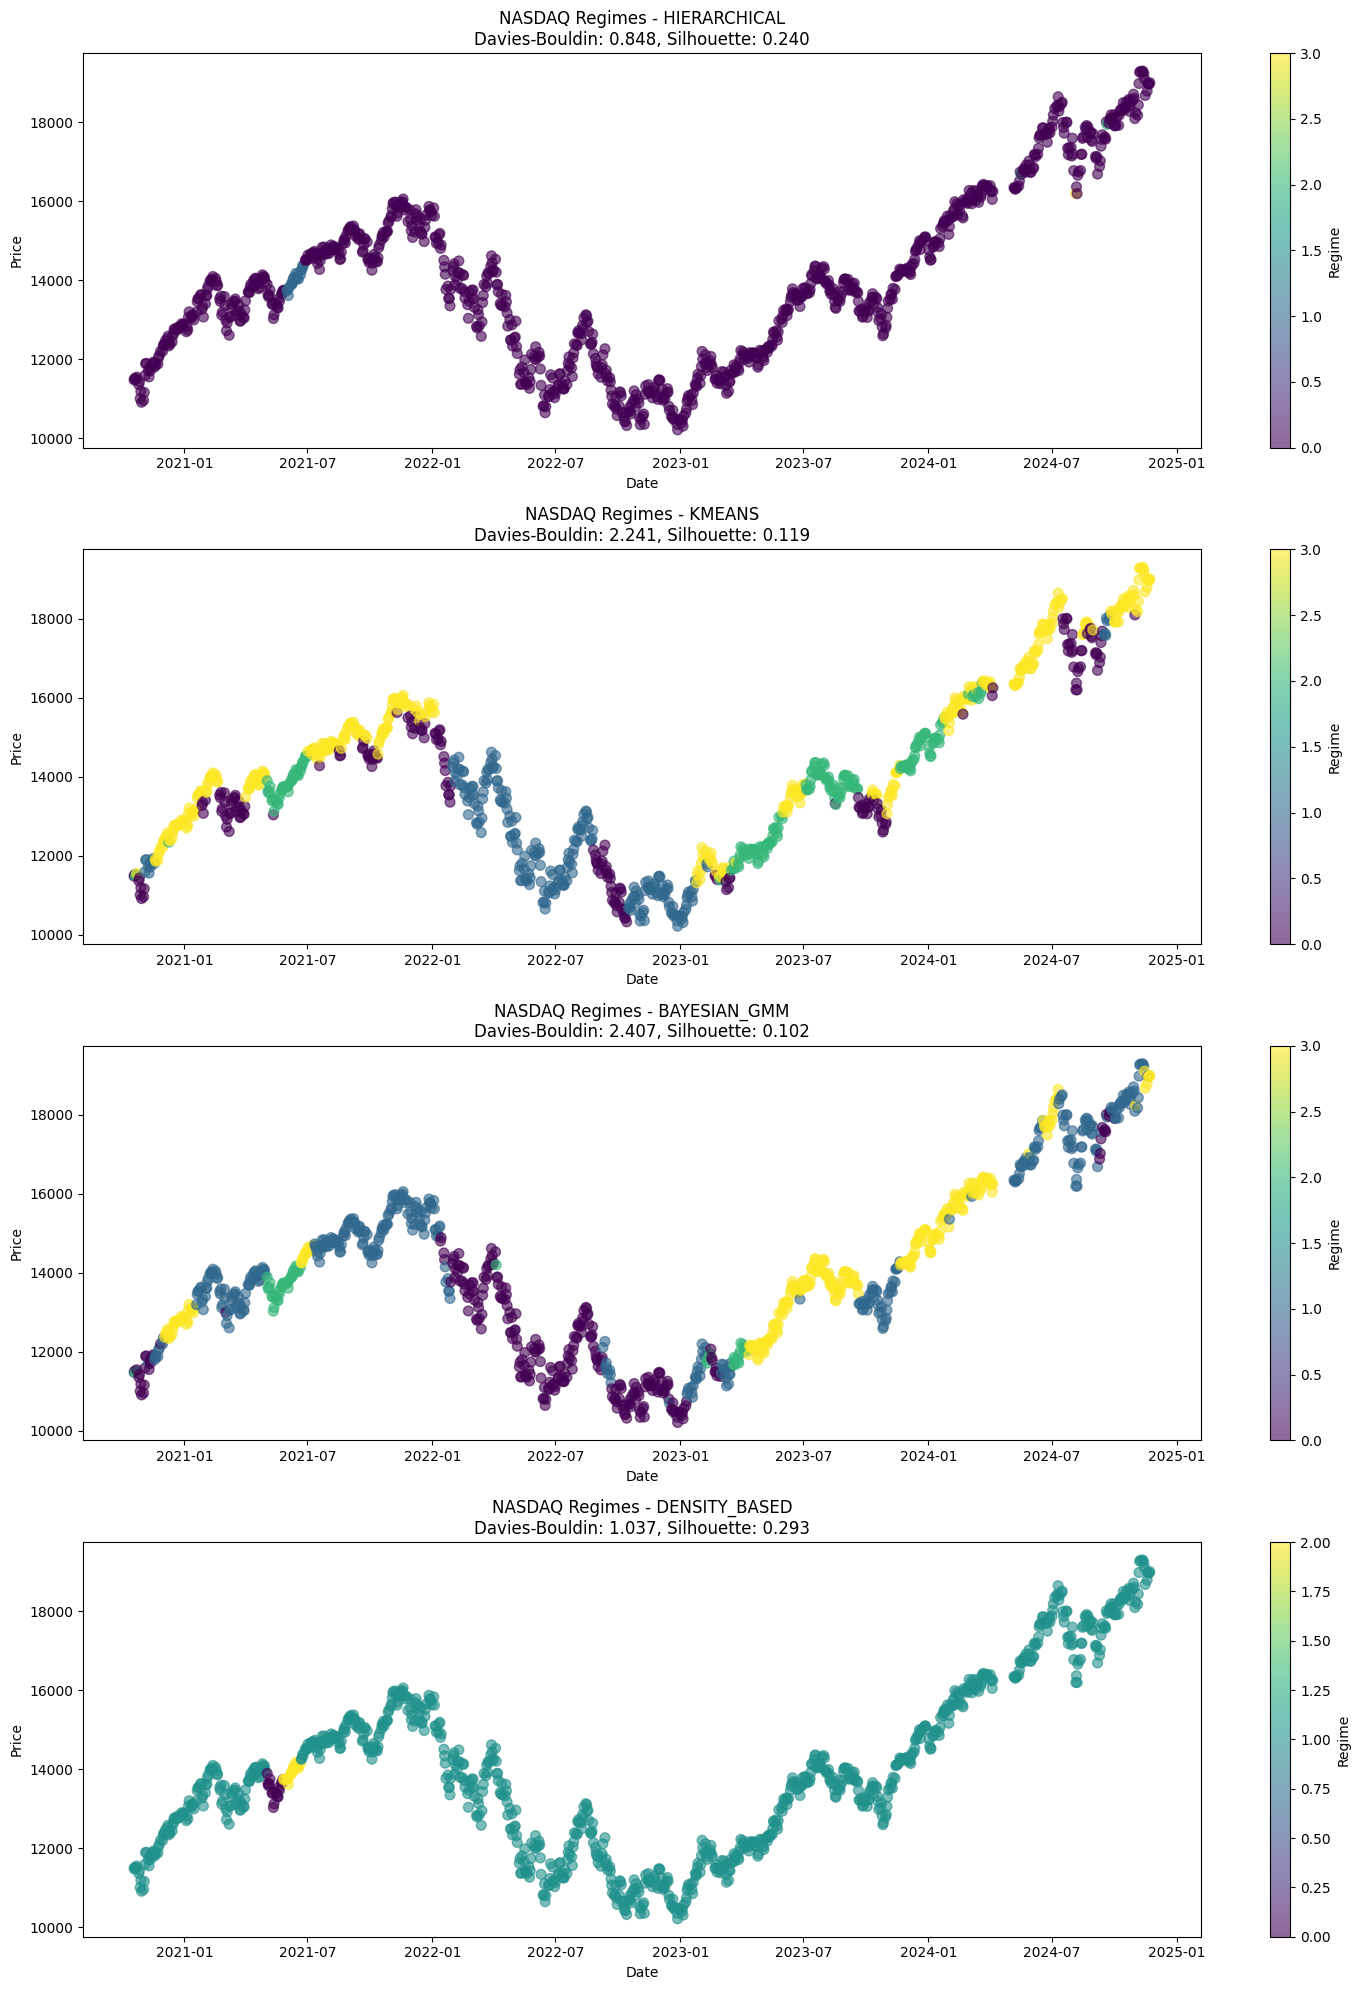

In [24]:
"""Visualize regimes from different methods"""
n_methods = len(regime_results)
fig, axes = plt.subplots(n_methods, 1, figsize=(15, 5*n_methods))

if n_methods == 1:
    axes = [axes]

for i, (method, results) in enumerate(regime_results.items()):
    ax = axes[i]
    scatter = ax.scatter(
        data.index[-len(results['regimes']):],
        data['close'][-len(results['regimes']):],
        c=results['regimes'],
        cmap='viridis',
        alpha=0.6,
        s=50
    )
    ax.set_title(f'NASDAQ Regimes - {method.upper()}\n'
                f'Davies-Bouldin: {results["davies_bouldin"]:.3f}, '
                f'Silhouette: {results["silhouette"]:.3f}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.colorbar(scatter, ax=ax, label='Regime')

plt.tight_layout()